Boruta Feature Selection
--
Boruta is a feature selection algorithm. Precisely, it works as a wrapper algorithm around Random Forest. Boruta follows an all-relevant feature selection method where it captures all features which are in some circumstances relevant to the outcome variable.

#### How it works?
Below is the step wise working of boruta algorithm:
1. Firstly, it adds randomness to the given data set by creating shuffled copies of all features (which are called shadow features).
2. Then, it trains a random forest classifier on the extended data set and applies a feature importance measure (the default is Mean Decrease Accuracy) to evaluate the importance of each feature where higher means more important.
3. At every iteration, it checks whether a real feature has a higher importance than the best of its shadow features (i.e. whether the feature has a higher Z score than the maximum Z score of its shadow features) and constantly removes features which are deemed highly unimportant.
4. Finally, the algorithm stops either when all features gets confirmed or rejected or it reaches a specified limit of random forest runs.

[Reference](analyticsvidhya.com/blog/2016/03/select-important-variables-boruta-package/)

In [1]:
import numpy as np
import pandas as pd
from boruta import BorutaPy
from numpy import mean, std
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

from preprocess import load_data

### Load Data

In [2]:
from preprocess import feature_scaling

GSE_list = ["GSE140261", "GSE115650", "Heuvel_expression"]
sig_list = ['DUX4_target', 'D4Z4_interactome', 'PAX7_target']
feature, label = load_data(GSE_list, sig_list, signature_version='v0')
feature = feature_scaling(feature, scaler='PowerTransformer')
label = label_binarize(label, classes=['FSHD', 'Control'])
X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size=.2, random_state=1)  # for boruta

### Random Forest Model (all features)

We first obtain the ROC_AUC score using all available features.

In [4]:
rf_all_features = RandomForestClassifier()

cv_splitter = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
cv_result = cross_validate(rf_all_features, feature, label.flatten(),
                           cv=cv_splitter,
                           verbose=1,
                           scoring=make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True),
                           n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.1s finished


In [5]:
cv_result

{'fit_time': array([0.480021  , 0.45151162, 0.44410825, 0.46247673, 0.49751949,
        0.42931151, 0.45930362, 0.46452689, 0.43365097, 0.42340398,
        0.48400211, 0.4745419 , 0.45529294, 0.44274282, 0.46195698,
        0.44282246, 0.45381284, 0.45320368, 0.41496181, 0.44342804,
        0.44396091, 0.46120906, 0.41444421, 0.41548347, 0.43422675,
        0.42354369, 0.43297124, 0.48543119, 0.46565723, 0.43361807,
        0.42400503, 0.42388058, 0.44201994, 0.41384006, 0.45377517,
        0.44124842, 0.43360162, 0.45131755, 0.44017124, 0.42200494,
        0.5448215 , 0.42284203, 0.43846321, 0.55493164, 0.58603954,
        0.49627018, 0.42677236, 0.43284559, 0.43295193, 0.43534255]),
 'score_time': array([0.04565525, 0.05068541, 0.03633332, 0.03934431, 0.04027963,
        0.04268575, 0.05136037, 0.0468545 , 0.04027534, 0.03818154,
        0.04004836, 0.05533361, 0.04009247, 0.04029369, 0.04028654,
        0.04026508, 0.03949928, 0.04071736, 0.03951764, 0.04747438,
        0.0383358 , 

In [6]:
print('ROC_AUC score for all tests:')
cv_result.get('test_score')

ROC_AUC score for all tests:


array([0.88333333, 0.58928571, 0.84821429, 0.73125   , 0.946875  ,
       0.69166667, 0.88988095, 0.83928571, 0.88125   , 0.846875  ,
       0.91111111, 0.88392857, 0.73214286, 0.7375    , 0.796875  ,
       0.8       , 0.80654762, 0.82738095, 0.79375   , 0.89375   ,
       0.89444444, 0.98809524, 0.86309524, 0.746875  , 0.51875   ,
       0.875     , 0.83333333, 0.62202381, 0.99375   , 0.803125  ,
       0.88055556, 0.75297619, 0.72916667, 0.765625  , 1.        ,
       0.97222222, 0.7827381 , 0.72916667, 0.715625  , 0.86875   ,
       0.71388889, 0.86904762, 0.8125    , 0.875     , 0.865625  ,
       0.70277778, 0.73511905, 0.98809524, 0.840625  , 0.81875   ])

In [7]:
print('Average ROC_AUC {:10.4f}'.format(mean(cv_result.get('test_score'))))
print('Std ROC_AUC {:10.4f}'.format(std(cv_result.get('test_score'))))

Average ROC_AUC     0.8178
Std ROC_AUC     0.1013


### Using Boruta for feature selection

In [8]:
rfc = RandomForestClassifier()
boruta_selector = BorutaPy(rfc, n_estimators='auto', alpha=0.10, perc=80, random_state=1)
boruta_selector.fit(np.array(X_train), np.array(y_train.ravel()))

BorutaPy(alpha=0.1,
         estimator=RandomForestClassifier(n_estimators=161,
                                          random_state=RandomState(MT19937) at 0x26BF49C5D40),
         n_estimators='auto', perc=80,
         random_state=RandomState(MT19937) at 0x26BF49C5D40)

In [9]:
print("Selected Features: ", boruta_selector.support_)  # check selected features

Selected Features:  [False False False False  True False False  True False False False  True
 False False False False False False  True False False False False False
 False False False False False False False  True False False  True False
 False False False False False False False False False False False False
 False False False  True False  True False  True  True False False  True
  True False  True False False False False False False False  True False
 False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True  True False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False False False  True False False  True False False  True
 False False  True  True False False False False False False False  True
  True False False False  True 

In [10]:
print("No. of significant features: ", boruta_selector.n_features_)

print("Ranking: ", boruta_selector.ranking_)  # check ranking of features

No. of significant features:  83
Ranking:  [359 154 457 129   1 437 125   1 399 427 269   1 101 156 314   2 152 384
   1  94 265 247 140  52  50 234 282 294 274  36 462   1 258  96   1 220
  56 327 390 413 218 260 355 311 168 146 285  74 256 197 151   1  18   1
 206   1   1 369 232   1   1  12   1 140 415 462 400  46 158 241   1 357
 457 156   1 287 346 186  44 178 178 349  85 422  36 432 259 301  62 361
 320  39 306 166 153  98  98 387  90 365 237 265 305  28 373 189 226 214
   1   1 193 411 323  22 397  78  39 452 252  90 254 281 235 157 314   1
 101 101 457  98 117 389 345 127 318 337 447   1 193 434   1   2 195   1
  12 331   1   1 214 200  60 408 447 422 406   1   1 171 462 241   1  87
   1 418   8 161  80 127 160 159 203 182  68 252 375  47 241 137  54 344
 288  76 447  31 107 125 193 316 262 452 457 184   1 209   2 320  82   1
 162 241   1 292 205 426  53  92   5 129 129 107 419  12 283 108 205  69
   1   8 234   1  64 360 405 341 347  82 357   1   2   1   1   1 355 120
 388   8

In [11]:
selected_rf_features = pd.DataFrame({'Feature': list(X_train.columns),
                                     'Ranking': boruta_selector.ranking_})
selected_rf_features.sort_values(by='Ranking')

,Feature,Ranking
277,CEP55,1
216,DEK,1
200,RDH10,1
197,MYOT,1
192,LTBP2,1
...,...,...
158,AMOTL2,462
65,SLC15A1,462
30,ASPM,462
430,BMP1,465


Then we get the important features based on Boruta feature selection. Here's the list of important features:

In [12]:
important_features_list = selected_rf_features[selected_rf_features['Ranking'] == 1]['Feature'].to_list()
important_features = feature[[gene for gene in feature.columns if gene in important_features_list]]
important_features_list

['MGST1',
 'DCN',
 'ATP1A2',
 'RAD51',
 'EML1',
 'RORA',
 'OSBPL6',
 'KIF22',
 'RAB21',
 'RBL1',
 'SERTAD4',
 'RRAGB',
 'NOX4',
 'CCDC80',
 'PTGS1',
 'MCM4',
 'PPP1R13L',
 'TRIM37',
 'MGP',
 'PHC1',
 'MAN1A1',
 'CAP2',
 'BVES',
 'LMNB1',
 'ARRDC3',
 'HYAL1',
 'STEAP3',
 'LTBP2',
 'MYOT',
 'RDH10',
 'DEK',
 'MCM8',
 'IRF5',
 'CGNL1',
 'DUT',
 'MBD4',
 'REEP2',
 'PCNA',
 'CCNA1',
 'NT5E',
 'SMC2',
 'KIF11',
 'CEP55',
 'POC1B',
 'FITM1',
 'ATP1B1',
 'DPT',
 'ZMYM3',
 'PRPS1',
 'CNKSR2',
 'FOXO1',
 'SUV39H2',
 'SPARCL1',
 'DDAH1',
 'ANKH',
 'TTC39B',
 'DCK',
 'FGF18',
 'IFNGR2',
 'SNX7',
 'PDLIM5',
 'FSTL1',
 'IGFBP7',
 'FBLN2',
 'RBM47',
 'EMCN',
 'MAD2L1',
 'KCNK5',
 'HTRA1',
 'HSPB7',
 'NET1',
 'MSRB3',
 'CMKLR1',
 'TBL1XR1',
 'DCTPP1',
 'PENK',
 'SKA2',
 'GAS6',
 'ADAP2',
 'CSF1',
 'DCUN1D3',
 'MFAP5',
 'HMGN2']

Finally, we use the same CV method as above to test model performance.

In [13]:
cv_result_refine = cross_validate(rf_all_features, important_features, label.flatten(),
                                  cv=cv_splitter,
                                  scoring=make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True),
                                  n_jobs=-1)

In [14]:
print('Average ROC_AUC {:10.4f}'.format(mean(cv_result_refine.get('test_score'))))
print('Std ROC_AUC {:10.4f}'.format(std(cv_result_refine.get('test_score'))))

Average ROC_AUC     0.8434
Std ROC_AUC     0.0990


### Tune Boruta

Based on previous experiments, we can see selecting important features does increase a performance of the classifier. But how many features can achieve the best performance?

In Boruta, ```perc``` a parameter that control how stringent the algorithm picks the relevant features. It's a user defined percentile that is used to pick the threshold for comparison between shadow and real features. The lower perc is the more false positives will be picked as relevant but also the less relevant features will be left out.

In the following section, we do a search for the optimal value of ```perc```.

In [15]:
# Define a function to tune boruta
def tune_boruta(perc_list, test_model):
    """
    Compare the performance (ROC_AUC) of different perc values
    :param perc_list: a list of perc values to compare
    :param test_model: the model to test on for the ROC_AUC score
    :return: score_df: a dataframe containing the performance of different perc values
    """
    scores = {'perc': [], 'Number_features': [], 'Average': [], 'Std': []}
    for perc in perc_list:
        print('Perc value: %s' % perc)
        scores.get('perc').append(perc)
        # Using Boruta for feature selction
        rfc = RandomForestClassifier()
        boruta_selector = BorutaPy(rfc, n_estimators='auto', alpha=0.10, perc=perc, random_state=1)
        boruta_selector.fit(np.array(X_train), np.array(y_train.ravel()))
        selected_rf_features = pd.DataFrame({'Feature': list(X_train.columns),
                                             'Ranking': boruta_selector.ranking_})
        important_features_list = selected_rf_features[selected_rf_features['Ranking'] == 1]['Feature'].to_list()
        important_features = feature[[gene for gene in feature.columns if gene in important_features_list]]
        num_features = len(important_features_list)
        scores.get('Number_features').append(num_features)
        print('Number of important features selected by Boruta: %s' % num_features)

        # Cross Validation using important features
        print('Cross validating using features selected...')
        cv_splitter = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
        cv_result = cross_validate(test_model, important_features, label.flatten(),
                                   cv=cv_splitter,
                                   scoring=make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True),
                                   n_jobs=-1)
        print('Cross validation finished!\n')
        scores.get('Average').append(mean(cv_result.get('test_score')))
        scores.get('Std').append(std(cv_result.get('test_score')))

    score_df = pd.DataFrame.from_dict(scores)
    score_df.set_index('Number_features', inplace=True)
    return score_df

- First step: coarse tuning with range 30-100, and 10 as interval

In [16]:
perc_list = [n for n in range(30, 101, 10)]

score_df_coarse = tune_boruta(perc_list, RandomForestClassifier())
score_df_coarse

Perc value: 30
Number of important features selected by Boruta: 299
Cross validating using features selected...
Cross validation finished!

Perc value: 40
Number of important features selected by Boruta: 233
Cross validating using features selected...
Cross validation finished!

Perc value: 50
Number of important features selected by Boruta: 187
Cross validating using features selected...
Cross validation finished!

Perc value: 60
Number of important features selected by Boruta: 151
Cross validating using features selected...
Cross validation finished!

Perc value: 70
Number of important features selected by Boruta: 107
Cross validating using features selected...
Cross validation finished!

Perc value: 80
Number of important features selected by Boruta: 83
Cross validating using features selected...
Cross validation finished!

Perc value: 90
Number of important features selected by Boruta: 50
Cross validating using features selected...
Cross validation finished!

Perc value: 100
Number

,perc,Average,Std
Number_features,,,
299,30,0.820673,0.100953
233,40,0.826533,0.102552
187,50,0.831552,0.098635
151,60,0.834048,0.097601
107,70,0.840177,0.094391
83,80,0.840095,0.095706
50,90,0.853997,0.092012
11,100,0.852953,0.080957


- Fine-tuning: testing from perc=90-100 since it's the range with the best performance.

In [17]:
perc_list = [n for n in range(90, 101, 2) if n % 10 != 0]  # remove multiple of 10 since already tested
score_df_fine = tune_boruta(perc_list, RandomForestClassifier())
score_df_fine

Perc value: 92
Number of important features selected by Boruta: 39
Cross validating using features selected...
Cross validation finished!

Perc value: 94
Number of important features selected by Boruta: 33
Cross validating using features selected...
Cross validation finished!

Perc value: 96
Number of important features selected by Boruta: 29
Cross validating using features selected...
Cross validation finished!

Perc value: 98
Number of important features selected by Boruta: 21
Cross validating using features selected...
Cross validation finished!



,perc,Average,Std
Number_features,,,
39,92,0.851827,0.097718
33,94,0.863335,0.084328
29,96,0.860745,0.084079
21,98,0.856876,0.081918


In [18]:
score_df = pd.concat([score_df_fine, score_df_coarse])
score_df = score_df.sort_values(by='Average', ascending=False)
score_df

,perc,Average,Std
Number_features,,,
33,94,0.863335,0.084328
29,96,0.860745,0.084079
21,98,0.856876,0.081918
50,90,0.853997,0.092012
11,100,0.852953,0.080957
39,92,0.851827,0.097718
107,70,0.840177,0.094391
83,80,0.840095,0.095706
151,60,0.834048,0.097601


- Plotting

In [19]:
def plotting(score_df, plt):
    score_df = score_df.sort_values(by='Number_features', ascending=False)
    plt.scatter(x=score_df.index, y=score_df['Average'], linestyle='-', marker='o')
    plt.xlabel('Number_features')
    plt.ylabel('ROC-AUC score')
    plt.title('Number of selected features v.s. Performance')
    plt.errorbar(score_df.index, score_df['Average'], yerr=score_df['Std'])
    plt.show()

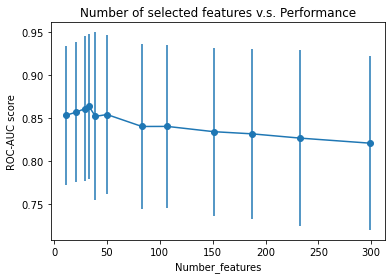

In [20]:
import matplotlib.pyplot as plt

plotting(score_df, plt)

In [21]:
print('The best performing parameter (perc) is:')
score_df.loc[score_df['Average'] == score_df.Average.max()]

The best performing parameter (perc) is:


,perc,Average,Std
Number_features,,,
33,94,0.863335,0.084328


##### Test on Another Model: Native Bayes

Native Bayes (Gaussian) is another model that shows good performance for the binary classification task. We also test how many features are optimal for the Native Bayes model.

In [22]:
score_df = score_df.sort_values(by='Average', ascending=False)
# Take first 10 perc value that yield best result in RF
perc_list = score_df.perc[0:4].to_list()
perc_list

[94, 96, 98, 90]

In [23]:
from sklearn.naive_bayes import GaussianNB
nb_score_df = tune_boruta(perc_list, GaussianNB())
nb_score_df

Perc value: 94
Number of important features selected by Boruta: 33
Cross validating using features selected...
Cross validation finished!

Perc value: 96
Number of important features selected by Boruta: 29
Cross validating using features selected...
Cross validation finished!

Perc value: 98
Number of important features selected by Boruta: 21
Cross validating using features selected...
Cross validation finished!

Perc value: 90
Number of important features selected by Boruta: 50
Cross validating using features selected...
Cross validation finished!



,perc,Average,Std
Number_features,,,
33,94,0.720694,0.076577
29,96,0.736494,0.080693
21,98,0.738478,0.077536
50,90,0.728526,0.077347


In [24]:
from sklearn.linear_model import LogisticRegression
nb_score_df = tune_boruta(perc_list, LogisticRegression())
nb_score_df

Perc value: 94
Number of important features selected by Boruta: 33
Cross validating using features selected...
Cross validation finished!

Perc value: 96
Number of important features selected by Boruta: 29
Cross validating using features selected...
Cross validation finished!

Perc value: 98
Number of important features selected by Boruta: 21
Cross validating using features selected...
Cross validation finished!

Perc value: 90
Number of important features selected by Boruta: 50
Cross validating using features selected...
Cross validation finished!



,perc,Average,Std
Number_features,,,
33,94,0.745242,0.093943
29,96,0.754534,0.096608
21,98,0.753571,0.094417
50,90,0.737050,0.092312


In [36]:
from sklearn.neural_network import MLPClassifier
nb_score_df = tune_boruta(perc_list, MLPClassifier())
nb_score_df

Perc value: 100
Number of important features selected by Boruta: 8
Cross validating using features selected...
Cross validation finished!

Perc value: 98
Number of important features selected by Boruta: 11
Cross validating using features selected...
Cross validation finished!

Perc value: 96
Number of important features selected by Boruta: 17
Cross validating using features selected...
Cross validation finished!



,perc,Average,Std
Number_features,,,
8,100,0.819380,0.144388
11,98,0.822949,0.138110
17,96,0.775801,0.152118


In [37]:
nb_score_df = nb_score_df.sort_values(by='Average', ascending=False)
nb_score_df

,perc,Average,Std
Number_features,,,
11,98,0.822949,0.138110
8,100,0.819380,0.144388
17,96,0.775801,0.152118


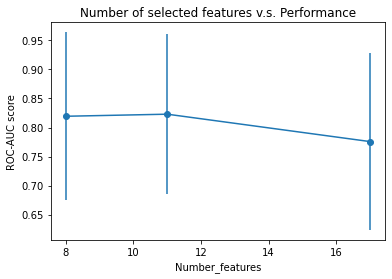

In [38]:
plotting(nb_score_df, plt)

In [39]:
print('The best performing parameter (perc) is:')
nb_score_df.loc[nb_score_df['Average'] == nb_score_df.Average.max()]

The best performing parameter (perc) is:


,perc,Average,Std
Number_features,,,
11,98,0.822949,0.13811


#### Best Performing Features (genes)

Since both RF and NB shows perc=98 (11 features) as the best performing, we get the 11 genes along with their signature

In [40]:
rfc = RandomForestClassifier()
boruta_selector = BorutaPy(rfc, n_estimators='auto', alpha=0.10, perc=100, random_state=1)
boruta_selector.fit(np.array(X_train), np.array(y_train.ravel()))
selected_rf_features = pd.DataFrame({'Feature': list(X_train.columns),
                                     'Ranking': boruta_selector.ranking_})
important_features_list = selected_rf_features[selected_rf_features['Ranking'] == 1]['Feature'].to_list()
important_features_list

['ATP1A2', 'PKP1', 'LAPTM4B', 'REEP2', 'ATP1B1', 'ZNF3', 'PLK1', 'JSRP1']

Add their corresponding signatures

In [41]:
from utils import read_gene_signature

sig = read_gene_signature()
sig_list = []

for gene in important_features_list:
    for key in sig:
        if gene in sig.get(key):
            sig_list.append(key)
            break
df = pd.DataFrame(list(zip(important_features_list, sig_list)),
                  columns=['Genes', 'Signatures'])
df.set_index('Genes')

,Signatures
Genes,
ATP1A2,PAX7_target
PKP1,PAX7_target
LAPTM4B,D4Z4_interactome
REEP2,PAX7_target
ATP1B1,PAX7_target
ZNF3,D4Z4_interactome
PLK1,PAX7_target
JSRP1,D4Z4_interactome
